# PERBANDINGAN METODE KLASTER K-MEDOIDS DAN K-MEANS TERHADAP HASIL PERAMALAN KEMISKINAN DI INDONESIA MENGGUNAKAN BPNN
### by Riansyah Fazar Ramadhan

## 1. Import Dependencies

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt

## 2. Data Preprocessing

In [2]:
data1 = pd.read_excel("E:/AKTUARIA FINAL SEASON/DATA/fpdata.xlsx", sheet_name="y", index_col=0)
data2 = pd.read_excel("E:/AKTUARIA FINAL SEASON/DATA/fpdata.xlsx", sheet_name="x1", index_col=0)
data3 = pd.read_excel("E:/AKTUARIA FINAL SEASON/DATA/fpdata.xlsx", sheet_name="x2", index_col=0)
data4 = pd.read_excel("E:/AKTUARIA FINAL SEASON/DATA/fpdata.xlsx", sheet_name="x3", index_col=0)

y = np.array(data1)
x1 = np.array(data2)
x2 = np.array(data3)
x3 = np.array(data4)

data1_flat = data1.values.flatten()
data2_flat = data2.values.flatten()
data3_flat = data3.values.flatten()
data4_flat = data4.values.flatten()

In [3]:
data = pd.DataFrame({
    'y': data1_flat,
    'x1': data2_flat,
    'x2': data3_flat,
    'x3': data4_flat
})
data

,y,x1,x2,x3
0,17.080000,-1.970,7.73,0.334000
1,10.530000,4.990,6.39,0.336000
2,7.310000,5.625,5.99,0.342000
3,8.420000,-1.035,6.72,0.364000
4,8.860000,4.555,2.73,0.361000
...,...,...,...,...
607,11.636808,5.675,2.27,0.361471
608,16.256020,4.650,6.31,0.282647
609,6.512500,21.560,4.31,0.311061
610,20.156875,4.790,5.38,0.370000


## 3. Descriptive Stats

In [4]:
desc_stat = data.describe()
desc_stat

,y,x1,x2,x3
count,612.000000,612.000000,612.000000,612.000000
mean,10.771365,4.553186,5.030539,0.352567
std,5.609865,4.048237,1.788318,0.040239
min,3.420000,-21.300000,0.880000,0.236000
25%,6.377500,3.530000,3.697500,0.324000
50%,9.035000,5.030000,4.655000,0.351000
75%,13.805000,5.765000,6.162500,0.381000
max,28.540000,25.860000,10.950000,0.459000


In [5]:
#writer = pd.ExcelWriter('pooled_data.xlsx', engine='xlsxwriter')
#with pd.ExcelWriter('pooled_data.xlsx', engine='xlsxwriter') as writer:
    #data.to_excel(writer, sheet_name='data', index=False)
    #desc_stat.to_excel(writer, sheet_name='desc_stat')

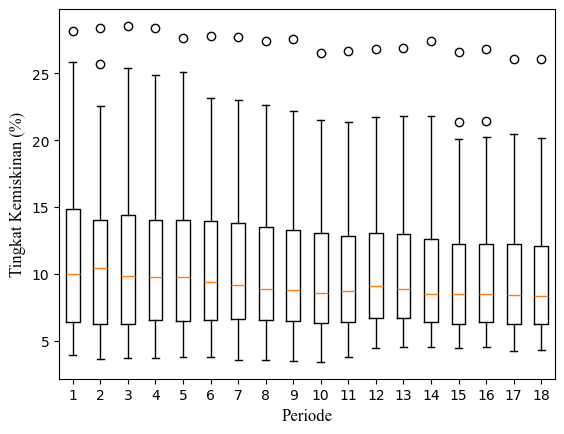

In [6]:
# Create a boxplot
font_prop = {'family': 'Times New Roman', 'color': 'black', 'weight': 'normal', 'size': 12}
plt.boxplot(data1.T)
plt.xlabel('Periode', fontdict=font_prop)
plt.ylabel('Tingkat Kemiskinan (%)', fontdict=font_prop)
plt.show()

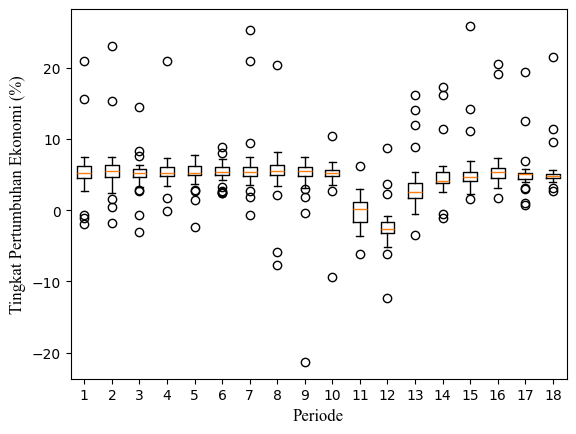

In [7]:
# Create a boxplot
font_prop = {'family': 'Times New Roman', 'color': 'black', 'weight': 'normal', 'size': 12}
plt.boxplot(data2.T)
plt.xlabel('Periode', fontdict=font_prop)
plt.ylabel('Tingkat Pertumbuhan Ekonomi (%)', fontdict=font_prop)
plt.show()

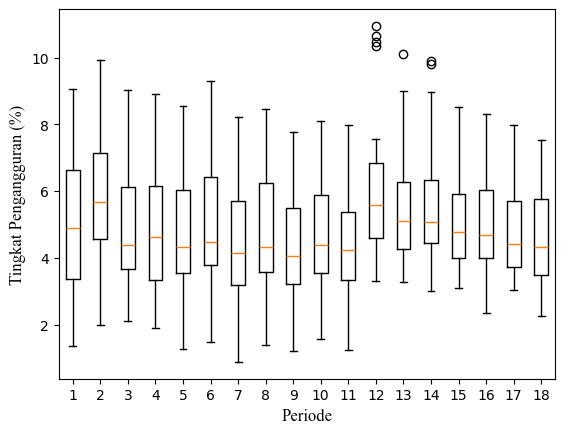

In [8]:
# Create a boxplot
font_prop = {'family': 'Times New Roman', 'color': 'black', 'weight': 'normal', 'size': 12}
plt.boxplot(data3.T)
plt.xlabel('Periode', fontdict=font_prop)
plt.ylabel('Tingkat Pengangguran (%)', fontdict=font_prop)
plt.show()

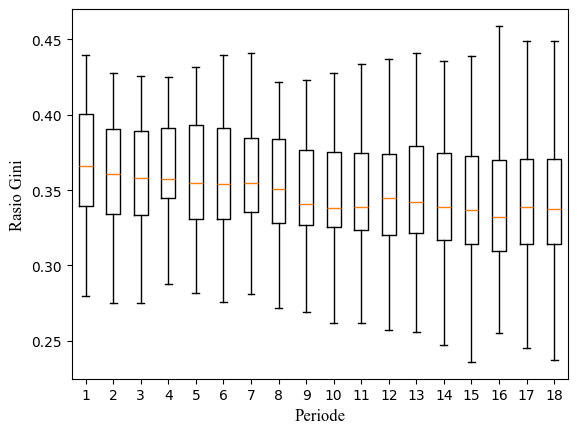

In [9]:
# Create a boxplot
font_prop = {'family': 'Times New Roman', 'color': 'black', 'weight': 'normal', 'size': 12}
plt.boxplot(data4.T)
plt.xlabel('Periode', fontdict=font_prop)
plt.ylabel('Rasio Gini', fontdict=font_prop)
plt.show()

## 4. Terasvirta Linearity Test
#### Done in R language, check at terasvirtatest.R

## 5. Min-max Normalization

In [19]:
from sklearn.preprocessing import MinMaxScaler

def normalize_data(data):
    scaler = MinMaxScaler(feature_range=(-1,1))
    data_norm = scaler.fit_transform(data)
    return data_norm, scaler

x1_norm, x1_scaler = normalize_data(data2_flat.reshape(-1,1))
x2_norm, x2_scaler = normalize_data(data3_flat.reshape(-1,1))
x3_norm, x3_scaler = normalize_data(data4_flat.reshape(-1,1))
y_norm, y_scaler = normalize_data(data1_flat.reshape(-1,1))

x1_data = x1_norm[34:612]
x2_data = x2_norm[34:612]
x3_data = x3_norm[34:612]
y_lag = y_norm[:578]
y_labels = y_norm[34:612]

In [20]:
data_norm = np.column_stack([y_labels, x1_data, x2_data, x3_data, y_lag])

## 6. Data Splitting & Prefetch

In [21]:
SPLIT_TIME = 476
data_train = data_norm[:SPLIT_TIME]
data_test = data_norm[SPLIT_TIME:]

In [22]:
def prefetch_dataset(features, labels, batch_size):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))
    return ds.batch(batch_size).prefetch(1)

In [23]:
train_features = data_train[:, 1:]  # Features
train_labels = data_train[:, 0]     # Labels
test_features = data_test[:, 1:]
test_labels = data_test[:, 0]

train_set = prefetch_dataset(train_features, train_labels, 1)
test_set = prefetch_dataset(test_features, test_labels, 1)

## 7. Backpropagation Neural Network

### Model Architecture

In [24]:
def modelling(train_dataset, test_dataset, epoch, loss_function, optimizer, activation, hidden_node, replication):
        model = tf.keras.models.Sequential([
                tf.keras.layers.Input(shape=(train_features.shape[1],)),
                tf.keras.layers.Dense(hidden_node, activation=activation),
                tf.keras.layers.Dense(1)
                ])
        model.compile(loss=loss_function, optimizer=optimizer)
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        history = model.fit(train_dataset, epochs=epoch, validation_data=test_dataset, callbacks=[early_stopping])
        if __name__ == '__main__':
                model.save(f"model_y_{replication}_{hidden_node}.h5")
        train_loss = history.history['loss'][-1]
        test_loss = history.history['val_loss'][-1]
        train_epoch = len(history.epoch)
        weights = model.get_weights()
        return train_loss, test_loss, train_epoch, weights[0], weights[1], weights[2], weights[3]

### Model Training and Replication

In [ ]:
model_sum = pd.DataFrame(columns=['replication', 'hidden_node', 'train_mse', 'test_mse', 'epoch', 'hl_weights', 'hl_bias', 'ol_weights', 'ol_bias'])
for rep in range(1, 6):
    iterasi = (rep - 1) * 20 + 1
    for n in range(1, 21):
        a,b,c,d,e,f,g = modelling(train_dataset=train_set, 
                                    test_dataset=test_set,
                                    epoch=50, 
                                    loss_function='mse',
                                    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                                    activation='relu',
                                    hidden_node=n,
                                    replication=rep)
        idx = iterasi + n
        model_sum.loc[idx] = [rep,n,a,b,c,d,e,f,g]
    model_sum.to_excel(f'main_model_summary.xlsx')

## 8. Model Prediction

### Input Data Preprocessing

In [39]:
# Load the input data from the Excel file
input_data_path = "E:\\GitHub\\sherlock-final-project\\x_prediction_3.xlsx"
input_data = pd.read_excel(input_data_path)

# Extract the relevant columns (assuming the columns are named 'x1', 'x2', 'x3')
x1_future = input_data['x1'].values
x2_future = input_data['x2'].values
x3_future = input_data['x3'].values

x1_future = x1_scaler.transform(x1_future.reshape(-1,1))
x2_future = x2_scaler.transform(x2_future.reshape(-1,1))
x3_future = x3_scaler.transform(x3_future.reshape(-1,1))
x4_future = np.zeros(136)
x4_future[:34] = y_norm[578:612].ravel()

combined_input = np.column_stack([x1_future, x2_future, x3_future, x4_future])

### Prediction using inputted data

1/1 [==============================] - 0s 23ms/step
[-0.14193714 -0.64056027 -0.8046169  -0.74174166 -0.67022467 -0.35380507
 -0.18155503 -0.41177726 -0.9118513  -0.8006934  -0.9178935  -0.6710248
 -0.42992532 -0.4169612  -0.4546839  -0.7867625  -0.9304583  -0.19293034
  0.28821146 -0.74995303 -0.8677044  -0.93194747 -0.78999376 -0.7546767
 -0.6890675  -0.30918896 -0.58346546 -0.36766756 -0.09060633 -0.3523686
  0.00576407 -0.7675071   0.3142814   0.7752789  -0.15386069 -0.6466242
 -0.80739903 -0.7436222  -0.671927   -0.3613354  -0.18965602 -0.4206698
 -0.9110776  -0.80534554 -0.91729593 -0.6763543  -0.4372394  -0.4221828
 -0.4613272  -0.7930937  -0.93047225 -0.20192039  0.27113217 -0.7554281
 -0.87129784 -0.93404484 -0.7949228  -0.7619083  -0.6942837  -0.32270348
 -0.5887095  -0.37403917 -0.10024691 -0.36046052 -0.01114494 -0.7789031
  0.29521418  0.75023156 -0.16600144 -0.65360725 -0.80983186 -0.7463505
 -0.67459655 -0.3697642  -0.19831944 -0.4307717  -0.91134393 -0.8102329
 -0.91730

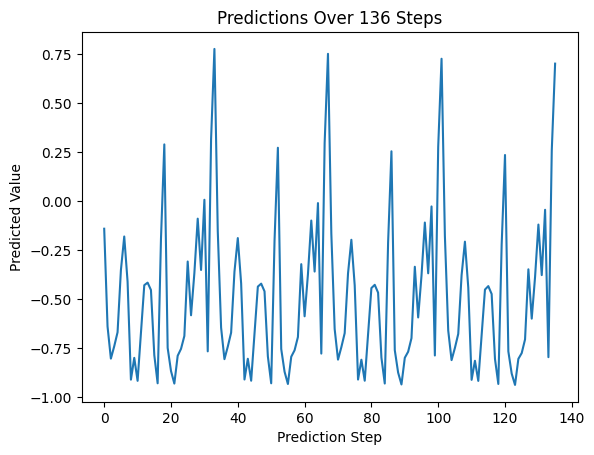

In [40]:
# Number of future data points to predict
num_predictions = 136

# Placeholder for the predictions
predictions = []

# Make sure your model is loaded correctly
# If the model is saved as 'model_x.h5', you can load it like this:
model = tf.keras.models.load_model('model_y_4_4.h5')

for i in range(num_predictions):
    # Predict the next data point
    next_pred = model.predict(combined_input[i].reshape(1, -1))
    
    # Append the prediction to the predictions list
    predictions.append(next_pred.squeeze())

    if i + 34 < 136:
        x4_future[i + 34] = next_pred.squeeze()
    
    # Update the combined input with the updated y_lag
    combined_input = np.column_stack([x1_future, x2_future, x3_future, x4_future])

# Convert the list of predictions to a NumPy array
y_predictions = np.array(predictions)

print(y_predictions)
plt.plot(y_predictions)
plt.xlabel('Prediction Step')
plt.ylabel('Predicted Value')
plt.title('Predictions Over 136 Steps')
plt.show()

### Prediction Result Denormalization

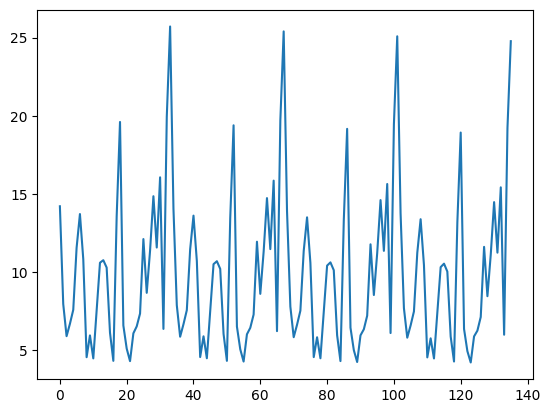

In [41]:
y_predictions = y_predictions.reshape(-1,1)
y_pred = y_scaler.inverse_transform(y_predictions).flatten()
plt.plot(y_pred)

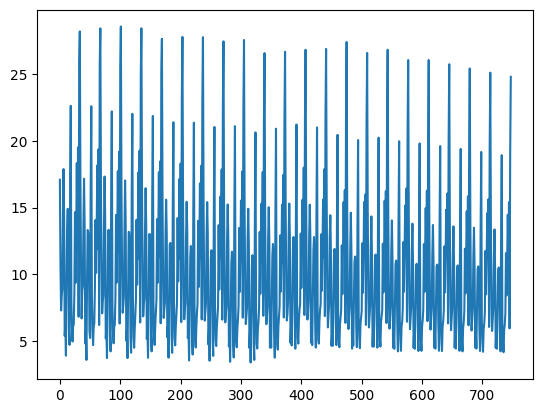

In [42]:
reshaped_previous_data = y.T

# Combine reshaped data and reshaped previous data
combined_data = np.concatenate((data1_flat, y_pred))

plt.plot(combined_data.reshape(-1,1))

In [43]:
model_pred = pd.DataFrame(y_pred, columns=['y'])
model_pred.to_excel('y_prediction.xlsx')